In [3]:
import pandas as pd
import pm4py


from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.statistics.traces.generic.log import case_statistics

import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster

In [4]:

# Data Import:
xes_path = "/Users/moritz_hawener/Documents/Work/Studium/Master/WS25/BPI/BPI Challenge 2017_1_all/BPI Challenge 2017.xes.gz"

# Read the XES log
event_log = xes_importer.apply(xes_path)

/opt/miniconda3/envs/bpi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [00:26<00:00, 1208.34it/s]


In [5]:
# Transform the event log to a pandas DataFrame
df = log_converter.apply(event_log, variant=log_converter.Variants.TO_DATA_FRAME)

In [6]:
roles = pm4py.discover_organizational_roles(
    df,
    resource_key='org:resource',
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:concept:name'
)

In [7]:
roles

[Activities: ['A_Accepted', 'A_Complete', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Complete application'] Originators importance {'User_10': 10090, 'User_100': 39, 'User_101': 22, 'User_102': 57, 'User_103': 78, 'User_104': 2401, 'User_105': 1037, 'User_106': 60, 'User_107': 17, 'User_108': 586, 'User_109': 198, 'User_11': 3059, 'User_110': 75, 'User_111': 24, 'User_12': 4627, 'User_13': 2570, 'User_132': 1161, 'User_135': 192, 'User_14': 5479, 'User_141': 145, 'User_15': 5692, 'User_16': 5681, 'User_17': 4555, 'User_18': 7642, 'User_19': 5039, 'User_2': 5111, 'User_20': 1018, 'User_21': 4145, 'User_22': 1160, 'User_23': 2815, 'User_24': 5066, 'User_25': 1941, 'User_26': 2990, 'User_27': 3419, 'User_28': 8097, 'User_29': 222, 'User_3': 11443, 'User_30': 108, 'User_31': 2061, 'User_32': 4064, 'User_33': 1691, 'User_34': 1837, 'User_35': 5790, 'User_36': 4412, 'User_37': 6965, 'User_38': 4084, 'User_39': 5876, 'User_4': 6170, 'User_40': 5762, 'User_41': 6064, 'User_4

In [8]:
roles[0].__dict__


{'activities': ['A_Accepted',
  'A_Complete',
  'O_Create Offer',
  'O_Created',
  'O_Sent (mail and online)',
  'W_Complete application'],
 'originator_importance': {'User_10': 10090,
  'User_100': 39,
  'User_101': 22,
  'User_102': 57,
  'User_103': 78,
  'User_104': 2401,
  'User_105': 1037,
  'User_106': 60,
  'User_107': 17,
  'User_108': 586,
  'User_109': 198,
  'User_11': 3059,
  'User_110': 75,
  'User_111': 24,
  'User_12': 4627,
  'User_13': 2570,
  'User_132': 1161,
  'User_135': 192,
  'User_14': 5479,
  'User_141': 145,
  'User_15': 5692,
  'User_16': 5681,
  'User_17': 4555,
  'User_18': 7642,
  'User_19': 5039,
  'User_2': 5111,
  'User_20': 1018,
  'User_21': 4145,
  'User_22': 1160,
  'User_23': 2815,
  'User_24': 5066,
  'User_25': 1941,
  'User_26': 2990,
  'User_27': 3419,
  'User_28': 8097,
  'User_29': 222,
  'User_3': 11443,
  'User_30': 108,
  'User_31': 2061,
  'User_32': 4064,
  'User_33': 1691,
  'User_34': 1837,
  'User_35': 5790,
  'User_36': 4412,
  'Use

### Resource availability probabilities

In [ ]:
#Extract resource availabillity from log
import json

def extract_resource_availability(df):
    
    # Extract temporal features
    df['weekday'] = df['time:timestamp'].dt.weekday
    df['hour'] = df['time:timestamp'].dt.hour
    
    # Count occurrences of each resource at each time slot
    # We normalize this to get a probability between 0 and 1
    availability = df.groupby(['org:resource', 'weekday', 'hour']).size().reset_index(name='counts')
    
    # Simple normalization: counts / max_counts_per_resource
    max_counts = availability.groupby('org:resource')['counts'].transform('max')
    availability['prob'] = availability['counts'] / max_counts
    
    # Convert to a dictionary for fast lookup: {(res, day, hour): prob}
    return availability.set_index(['org:resource', 'weekday', 'hour'])['prob'].to_dict()

def export_availability_to_json(availability_dict, filename="resource_availability.json"):
    # Convert tuple keys (res, day, hour) to string keys "res|day|hour" for JSON compatibility
    exportable_dict = {f"{k[0]}|{k[1]}|{k[2]}": v for k, v in availability_dict.items()}
    
    with open(filename, 'w') as f:
        json.dump(exportable_dict, f, indent=4)
    print(f"Successfully exported to {filename}")

In [ ]:
avail_props = extract_resource_availability(df)
export_availability_to_json(avail_props)

Successfully exported to resource_availability.json


In [ ]:
avail_props

{('User_1', 0, 0): 0.017890191239975324,
 ('User_1', 0, 1): 0.00987045033929673,
 ('User_1', 0, 2): 0.005552128315854411,
 ('User_1', 0, 3): 0.008019740900678593,
 ('User_1', 0, 4): 0.00987045033929673,
 ('User_1', 0, 5): 0.03701418877236274,
 ('User_1', 0, 6): 0.7538556446637877,
 ('User_1', 0, 7): 0.602508739461238,
 ('User_1', 0, 8): 0.22167386387003907,
 ('User_1', 0, 9): 0.2545753650010282,
 ('User_1', 0, 10): 0.26629652477894306,
 ('User_1', 0, 11): 0.27390499691548426,
 ('User_1', 0, 12): 0.31153608883405304,
 ('User_1', 0, 13): 0.28315854410857494,
 ('User_1', 0, 14): 0.2646514497223936,
 ('User_1', 0, 15): 0.22270203578038247,
 ('User_1', 0, 16): 0.2652683528685996,
 ('User_1', 0, 17): 0.2677359654534238,
 ('User_1', 0, 18): 0.3066008636644047,
 ('User_1', 0, 19): 0.29302899444787167,
 ('User_1', 0, 20): 0.26588525601480567,
 ('User_1', 0, 21): 0.25375282747275346,
 ('User_1', 0, 22): 0.19370758790869833,
 ('User_1', 0, 23): 0.09520871889779971,
 ('User_1', 1, 0): 0.0197409006

### Cluster activities by resources 

In [9]:
# Pearson’s correlation coefficient 

activity_user = {}

for role in roles:
    for act in role.activities:
        activity_user[act] = role.originator_importance

In [10]:
resource_allocation_df = (
    pd.DataFrame(activity_user)
    .fillna(0)
    .astype(float)
)


In [11]:
resource_allocation_df

,A_Accepted,A_Complete,O_Create Offer,O_Created,O_Sent (mail and online),W_Complete application,A_Cancelled,A_Concept,A_Create Application,W_Handle leads,...,W_Call after offers,W_Call incomplete files,W_Validate application,O_Cancelled,O_Sent (online only),A_Incomplete,W_Assess potential fraud,W_Shortened completion,W_Personal Loan collection,A_Submitted
User_10,10090.0,10090.0,10090.0,10090.0,10090.0,10090.0,1197.0,1197.0,1197.0,1197.0,...,3424.0,1053.0,303.0,142.0,31.0,6.0,2.0,0.0,0.0,0.0
User_100,39.0,39.0,39.0,39.0,39.0,39.0,8.0,8.0,8.0,8.0,...,28.0,7659.0,7675.0,220.0,3.0,2486.0,188.0,0.0,0.0,0.0
User_101,22.0,22.0,22.0,22.0,22.0,22.0,6.0,6.0,6.0,6.0,...,6.0,3306.0,1408.0,0.0,3.0,1102.0,27.0,0.0,0.0,0.0
User_102,57.0,57.0,57.0,57.0,57.0,57.0,13.0,13.0,13.0,13.0,...,21.0,1861.0,3153.0,282.0,3.0,609.0,39.0,0.0,0.0,0.0
User_103,78.0,78.0,78.0,78.0,78.0,78.0,21.0,21.0,21.0,21.0,...,27.0,4.0,8.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,650.0,1062.0,3340.0,22.0,0.0,186.0,0.0,0.0,0.0,0.0
User_134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,495.0,797.0,2221.0,30.0,0.0,165.0,2.0,0.0,0.0,0.0
User_137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,133.0,171.0,594.0,2.0,0.0,35.0,3.0,0.0,0.0,0.0
User_139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,28.0,44.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0


In [12]:


df_log = np.log1p(resource_allocation_df)


In [13]:
corr_matrix = df_log.corr(method="pearson")
distance = 1 - corr_matrix


In [14]:
Z = linkage(squareform(distance), method="average")


In [24]:
clusters = fcluster(Z, t=5, criterion="maxclust")

activity_clusters = pd.Series(
    clusters,
    index=corr_matrix.columns,
    name="cluster"
).sort_values()


In [25]:
activity_clusters

A_Accepted                    1
A_Complete                    1
O_Create Offer                1
O_Created                     1
O_Sent (mail and online)      1
W_Complete application        1
A_Cancelled                   1
A_Concept                     1
A_Create Application          1
W_Handle leads                1
O_Sent (online only)          1
W_Call after offers           1
W_Shortened completion        2
A_Submitted                   3
A_Pending                     4
O_Accepted                    4
W_Call incomplete files       4
W_Validate application        4
O_Cancelled                   4
O_Returned                    4
A_Incomplete                  4
W_Assess potential fraud      4
A_Validating                  4
O_Refused                     4
A_Denied                      4
W_Personal Loan collection    5
Name: cluster, dtype: int32

In [26]:
cluster_resource_counts = {}

for cluster_id in activity_clusters.unique():
    # activities belonging to this cluster
    cluster_activities = activity_clusters[
        activity_clusters == cluster_id
    ].index

    # users who worked on at least one of those activities
    users_in_cluster = (
        resource_allocation_df[cluster_activities]
        .sum(axis=1) > 0
    )

    cluster_resource_counts[cluster_id] = users_in_cluster.sum()

cluster_resource_counts = pd.Series(
    cluster_resource_counts,
    name="num_resources"
).sort_index()


In [ ]:
cluster_resource_counts # Results show that 1 & 4 are general activities which can be done by any users whereas 2, 3 & 5 are specific to a user (experts)

1    147
2     15
3      1
4    145
5      7
Name: num_resources, dtype: int64

In [19]:
# All activities mapped to clusters
all_cluster_activities = [activity for activity in activity_clusters.index]

# Users who worked in any cluster
users_any_cluster = (resource_allocation_df[all_cluster_activities].sum(axis=1) > 0).sum()

users_any_cluster


np.int64(149)

In [ ]:
# Create a dictionary where keys are clusters and values are lists of resources
resource_to_cluster = {}
for cluster_id in activity_clusters.unique():
    cluster_acts = activity_clusters[activity_clusters == cluster_id].index
    # Resources with non-zero importance for these activities
    resources = resource_allocation_df[cluster_acts].sum(axis=1)
    resource_to_cluster[cluster_id] = resources[resources > 0].index.tolist()

# Create an activity-to-cluster lookup
activity_to_cluster = activity_clusters.to_dict()

In [23]:
activity_to_cluster

{'A_Accepted': 1,
 'W_Shortened completion ': 1,
 'O_Sent (online only)': 1,
 'W_Call after offers': 1,
 'W_Handle leads': 1,
 'A_Create Application': 1,
 'A_Concept': 1,
 'A_Submitted': 1,
 'W_Complete application': 1,
 'A_Complete': 1,
 'O_Create Offer': 1,
 'A_Cancelled': 1,
 'O_Created': 1,
 'O_Sent (mail and online)': 1,
 'O_Refused': 2,
 'A_Pending': 2,
 'O_Accepted': 2,
 'O_Returned': 2,
 'W_Call incomplete files': 2,
 'W_Validate application': 2,
 'O_Cancelled': 2,
 'A_Validating': 2,
 'A_Incomplete': 2,
 'W_Assess potential fraud': 2,
 'A_Denied': 2,
 'W_Personal Loan collection': 3}

In [ ]:
# Create a mapping of Activity -> List of allowed Users
permission_map = {}

for activity, cluster_id in activity_clusters.items():
    # Identify users who have 'Importance' in this cluster
    # We use a threshold to ensure they actually perform the task regularly

    cluster_acts = activity_clusters[activity_clusters == cluster_id].index
    mask = resource_allocation_df[cluster_acts].sum(axis=1) > 0
    allowed_resources = resource_allocation_df.index[mask].tolist()
    
    permission_map[activity] = allowed_resources

# Now, in your simulator's select_resource function:
# def get_resource(activity_name):
#     pool = permission_map.get(activity_name)
#     return find_earliest_available(pool)

{'A_Accepted': ['User_10',
  'User_100',
  'User_101',
  'User_102',
  'User_103',
  'User_104',
  'User_105',
  'User_106',
  'User_107',
  'User_108',
  'User_109',
  'User_11',
  'User_110',
  'User_111',
  'User_12',
  'User_13',
  'User_132',
  'User_135',
  'User_14',
  'User_141',
  'User_15',
  'User_16',
  'User_17',
  'User_18',
  'User_19',
  'User_2',
  'User_20',
  'User_21',
  'User_22',
  'User_23',
  'User_24',
  'User_25',
  'User_26',
  'User_27',
  'User_28',
  'User_29',
  'User_3',
  'User_30',
  'User_31',
  'User_32',
  'User_33',
  'User_34',
  'User_35',
  'User_36',
  'User_37',
  'User_38',
  'User_39',
  'User_4',
  'User_40',
  'User_41',
  'User_42',
  'User_43',
  'User_44',
  'User_45',
  'User_46',
  'User_47',
  'User_48',
  'User_49',
  'User_5',
  'User_50',
  'User_51',
  'User_52',
  'User_53',
  'User_54',
  'User_55',
  'User_56',
  'User_57',
  'User_58',
  'User_59',
  'User_6',
  'User_60',
  'User_61',
  'User_62',
  'User_63',
  'User_64',
 

/var/folders/rz/nvdgk3v95fxdx4m351hjk33w0000gn/T/ipykernel_75710/2615411865.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sizes.index, y=sizes.values, palette="rocket")


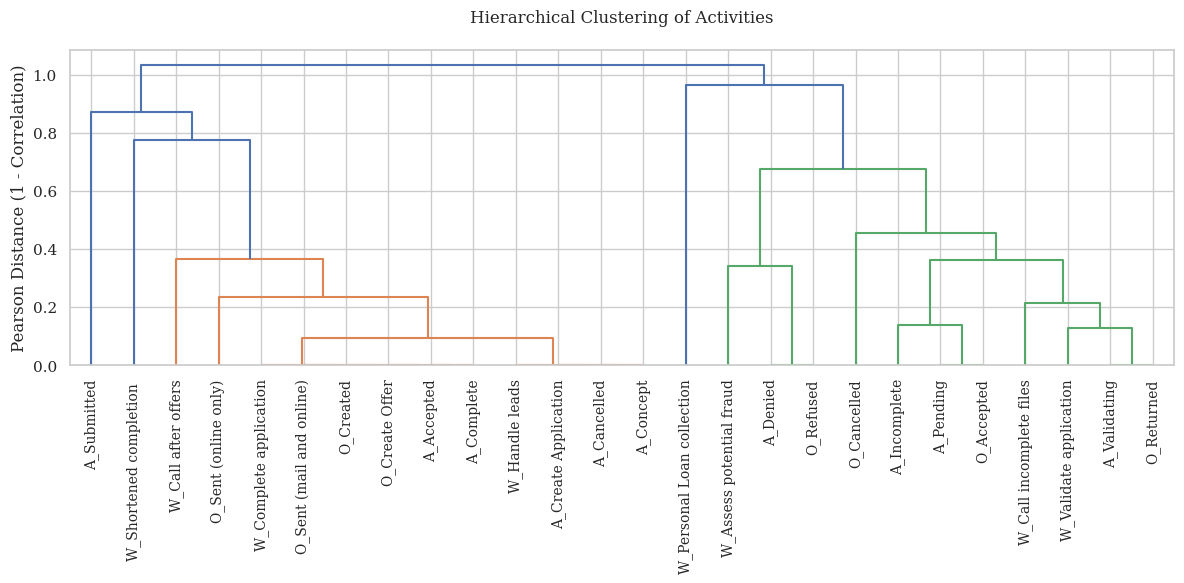

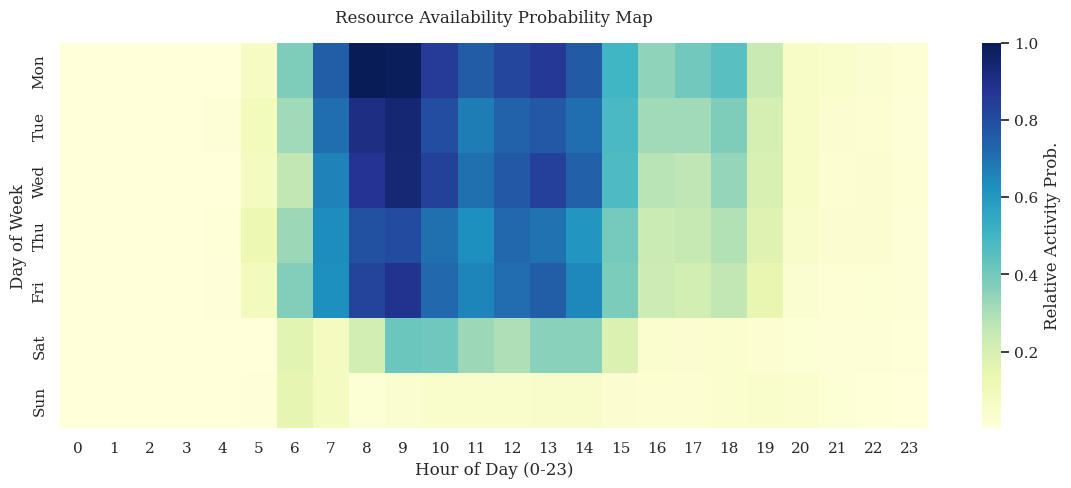

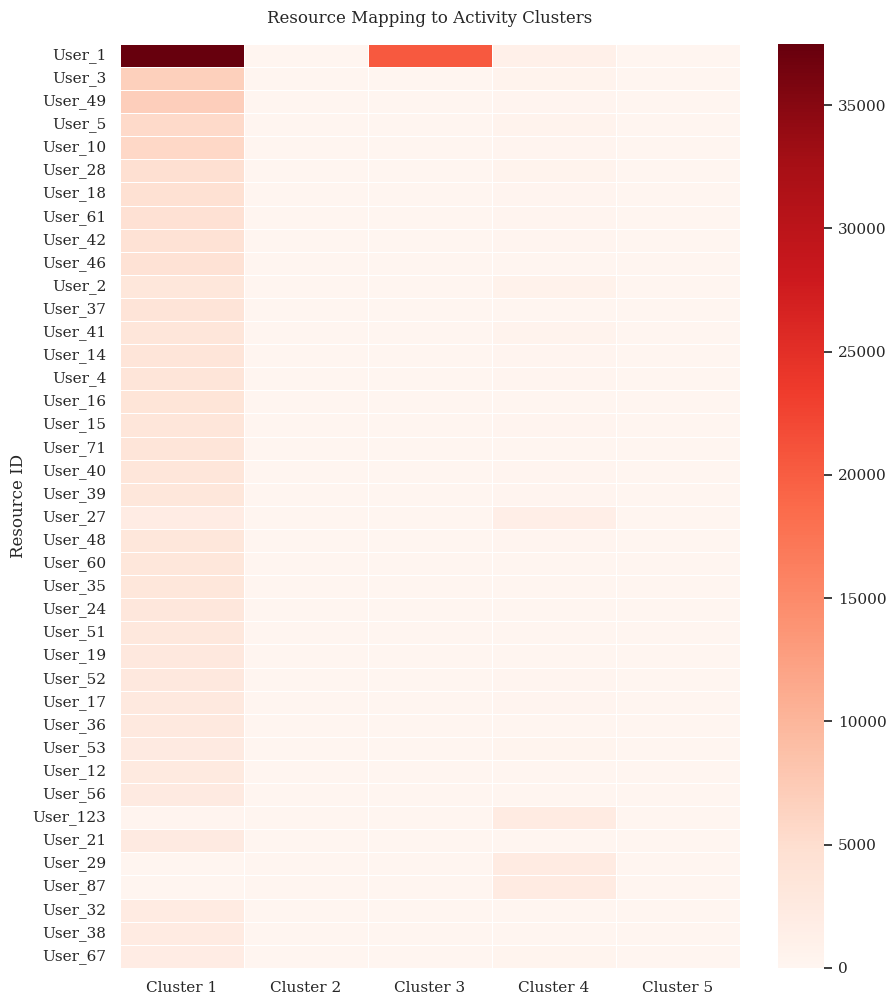

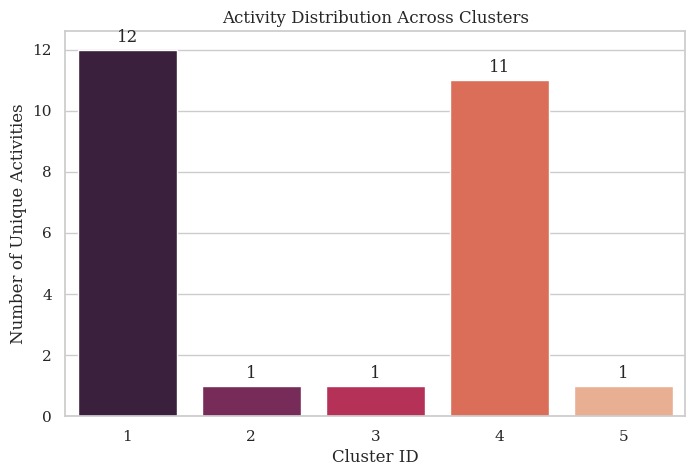

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.cluster.hierarchy import dendrogram

def generate_paper_visualizations(Z, activity_clusters, resource_allocation_df, df):
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

    plt.figure(figsize=(12, 6))
    dendrogram(Z, labels=resource_allocation_df.columns, leaf_rotation=90, color_threshold=0.7)
    plt.title("Hierarchical Clustering of Activities", pad=20)
    plt.ylabel("Pearson Distance (1 - Correlation)")
    plt.tight_layout()
    plt.savefig("fig_activity_dendrogram.png", dpi=300)

    df['weekday'] = df['time:timestamp'].dt.weekday
    df['hour'] = df['time:timestamp'].dt.hour
    
    avail_map = df.groupby(['weekday', 'hour']).size().unstack(fill_value=0)
    avail_map = avail_map / avail_map.max().max()

    plt.figure(figsize=(14, 5))
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    sns.heatmap(avail_map, cmap="YlGnBu", xticklabels=range(24), yticklabels=days, cbar_kws={'label': 'Relative Activity Prob.'})
    plt.title("Resource Availability Probability Map", pad=15)
    plt.xlabel("Hour of Day (0-23)")
    plt.ylabel("Day of Week")
    plt.savefig("fig_temporal_availability.png", dpi=300)

    cluster_data = [resource_allocation_df[activity_clusters[activity_clusters == cid].index].mean(axis=1) 
                    for cid in sorted(activity_clusters.unique())]
    
    res_cluster_matrix = pd.concat(cluster_data, axis=1)
    res_cluster_matrix.columns = [f"Cluster {c}" for c in sorted(activity_clusters.unique())]

    top_res = res_cluster_matrix.sum(axis=1).sort_values(ascending=False).head(40).index
    plt.figure(figsize=(10, 12))
    sns.heatmap(res_cluster_matrix.loc[top_res], cmap="Reds", annot=False, linewidths=.5)
    plt.title("Resource Mapping to Activity Clusters", pad=15)
    plt.ylabel("Resource ID")
    plt.savefig("fig_resource_permissions.png", dpi=300)

    plt.figure(figsize=(8, 5))
    sizes = activity_clusters.value_counts().sort_index()
    ax = sns.barplot(x=sizes.index, y=sizes.values, palette="rocket")
    plt.title("Activity Distribution Across Clusters")
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Unique Activities")
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    plt.savefig("fig_cluster_distribution.png", dpi=300)

generate_paper_visualizations(Z, activity_clusters, resource_allocation_df, df)